## RNN

A Recurrent Neural Network (RNN) is a type of neural network that allow previous outputs to be used as inputs while having hidden states. There are many subclasses of RNNs as well and we will be covering those later as well.

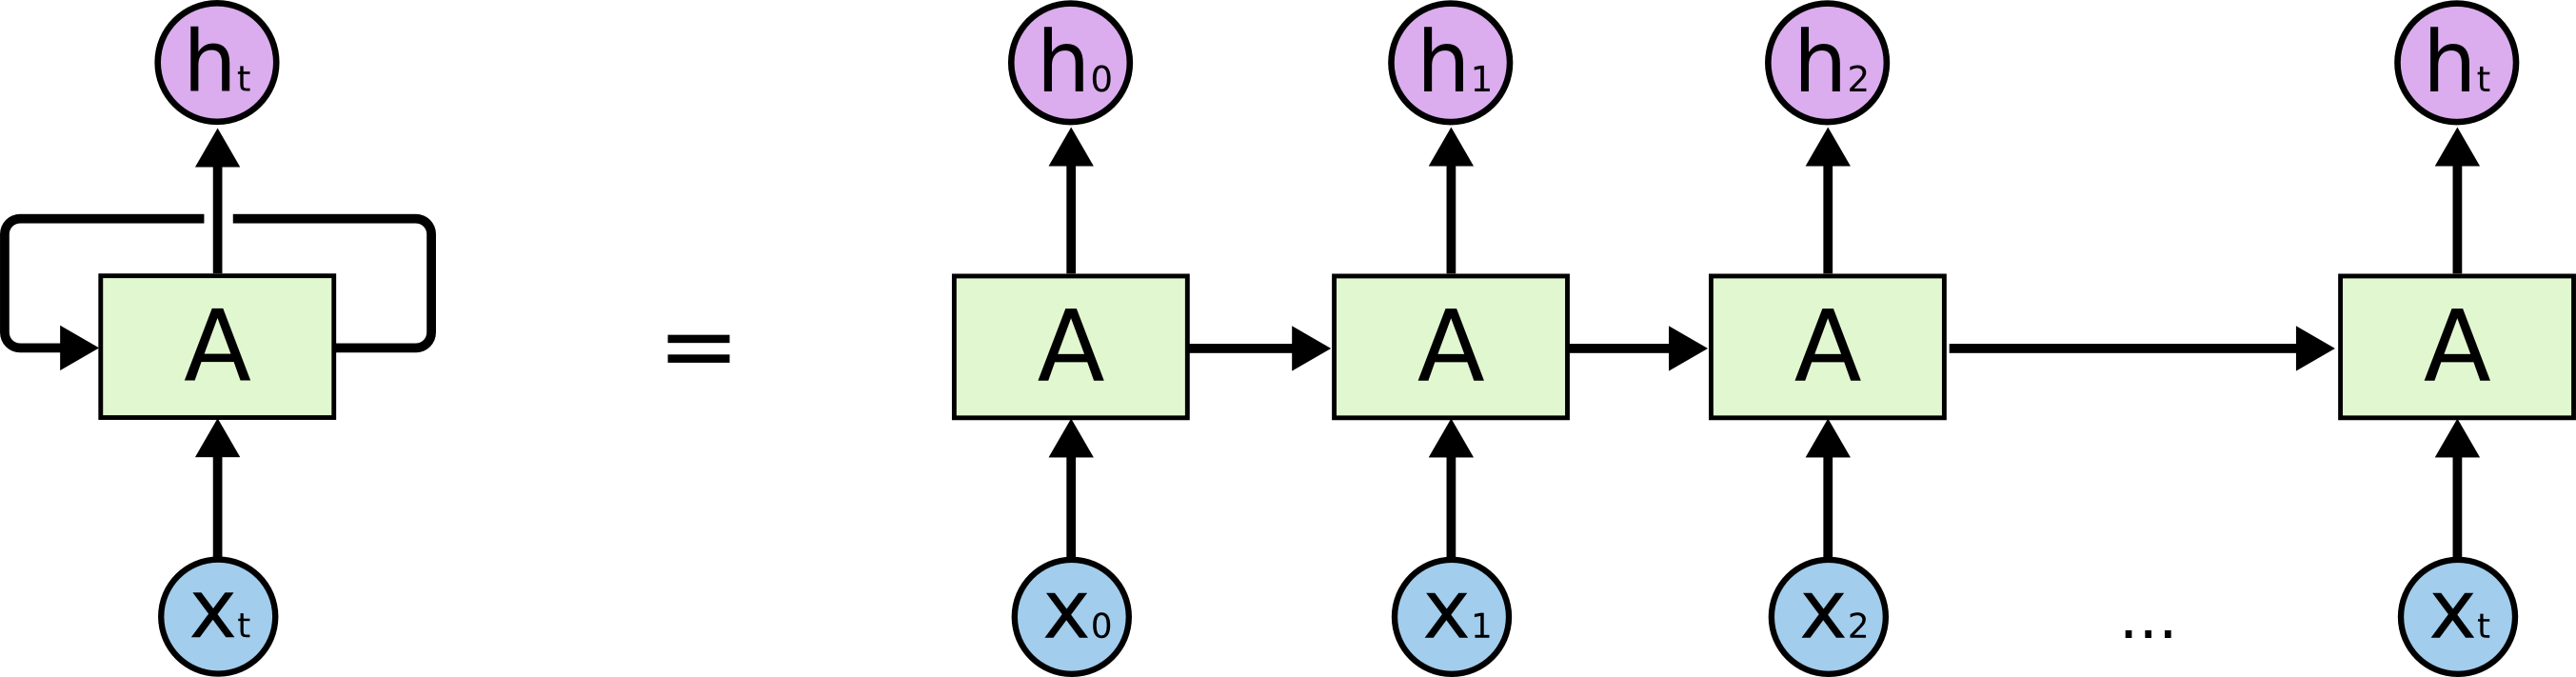

Above is a graphic displaying how an RNN works. This type specifically is popular for name-entity recognition. The main advantage of using an RNN is that it uses historical information amongst shared weights. This however does deal one major drawback, the computation time. Back-propagation for RNNs are done at each point in time. The activation functions being used can be sigmoid, ReLU, or tanh but one issue is the vanishing gradient problem. To combat this, we can cap the activation function. 

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2022-08-15 20:33:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-15 20:33:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-15 20:33:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchtext.vocab import Vectors, GloVe, FastText, CharNGram, build_vocab_from_iterator
from torchtext.data import get_tokenizer

import pandas as pd
import numpy as np
import os

In [8]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)


class RNN(nn.Module):
    def __init__(self, newEmbedding, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(newEmbedding, freeze = False)
        self.rnn = nn.RNN(self.embedding.num_embeddings, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)

        assert torch.equal(output[-1, :, :], hidden.squeeze(0))

        return self.fc(hidden.squeeze(0))


class LSTM(nn.Module):
    def __init__(self, newEmbedding, hidden_dim, output_dim,
                 n_layers=1, use_bidirectional=False, use_dropout=False):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(newEmbedding, freeze = False)
        self.rnn = nn.LSTM(self.embedding.num_embeddings, hidden_dim, num_layers=n_layers,
                           bidirectional=use_bidirectional,
                           dropout=0.5 if use_dropout else 0.)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5 if use_dropout else 0.)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedded)
        # seq len * batch * embedd
        # print(output.shape)
        # output = output.max(0)[0]
        # print(output.shape)

        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]),
                                        dim=1))

        return self.fc(hidden.squeeze(0))
        # return self.fc(self.dropout(output))


class CNN(nn.Module):
    def __init__(self, vocab_size, newEmbedding, n_filters, filter_sizes,
                 output_dim, use_dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(newEmbedding, freeze = False)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters,
                      kernel_size=(fs, self.embedding.num_embeddings)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(0.5 if use_dropout else 0.)

    def forward(self, x):
        x = x.permute(1, 0)
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=1))

        return self.fc(cat)


class LSTM_with_Attention(nn.Module):
    def __init__(self, newEmbedding, hidden_dim, output_dim,
                 n_layers=1, use_bidirectional=False, use_dropout=False):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(newEmbedding, freeze = False)
        self.rnn = nn.LSTM(self.embedding.num_embeddings, hidden_dim // 2,
                           bidirectional=use_bidirectional,
                           dropout=0.5 if use_dropout else 0.)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5 if use_dropout else 0.)

    def attention_net(self, lstm_output, final_state):
        lstm_output = lstm_output.permute(1, 0, 2)
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, dim=1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2),
                                     soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state

    def attention(self, lstm_output, final_state):
        lstm_output = lstm_output.permute(1, 0, 2)
        merged_state = torch.cat([s for s in final_state], 1)
        merged_state = merged_state.squeeze(0).unsqueeze(2)
        weights = torch.bmm(lstm_output, merged_state)
        weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
        return torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedded)

        # attn_output = self.attention_net(output, hidden)
        attn_output = self.attention(output, hidden)

        return self.fc(attn_output.squeeze(0))

In [12]:
gloveEmbedding = GloVe(name='6B', dim=100)
ftEmbedding = FastText('simple')
cngEmbedding = CharNGram()

100%|███████████████████████████████▉| 399999/400000 [00:11<00:00, 34275.35it/s]
.vector_cache/wiki.simple.vec: 293MB [00:09, 32.1MB/s]                          
100%|████████████████████████████████| 111051/111051 [00:07<00:00, 14474.80it/s]
.vector_cache/jmt_pre-trained_embeddings.tar.gz: 956MB [00:40, 23.5MB/s]        
100%|███████████████████████████████▉| 874473/874474 [00:27<00:00, 31912.42it/s]


In [16]:
torch.manual_seed(1234)
"""
TEXT = Field(sequential=True, use_vocab=True, tokenizer_language='en_core_web_sm',
                  tokenize='spacy', lower=True, batch_first=True)
LABEL = LabelField(dtype=torch.float)
vectors = Vectors(name='mr_vocab.txt', cache='./')
dataset_path = os.path.join(root_dir, '{}.tsv')

for target in ['train', 'dev', 'test']:
    dataset[target] = TabularDataset(
        path=dataset_path.format(target),
        format='tsv',
        fields=[('text', TEXT), ('label', LABEL)]
    )
    if use_vector:
        TEXT.build_vocab(dataset[target], max_size=25000, vectors=vectors)
    else:
        TEXT.build_vocab(dataset[target], max_size=25000)

    LABEL.build_vocab(self.dataset[target])
    dataloader[target] = Iterator(dataset[target], batch_size=batch_size, device=pdevice,
                                       repeat=False, sort_key=lambda x: len(x.text), shuffle=True)
"""

dataset = {}
dataloader = {}
tokenizer = get_tokenizer("basic_english")

for target in ['train', 'dev', 'test']:
    word_to_index = {}
    word_vectors = []
    with open('data/'+target+'.tsv') as fp:
        for line in fp.readlines():
            line = line.split(" ")
            word = line[0]
            vec = np.array([float(x) for x in line[1:]])
            word_to_index[word] = len(word_to_index)
            word_vectors.append(vec)
            
    dataset[target] = cls(word_to_index, word_vectors)

    
    # dataset[target] = build_vocab_from_iterator(tokenizer, csv.reader('data/'+target+'.tsv', delimiter="\t"))

NameError: name 'Field' is not defined

In [ ]:
def generate_experiment_name():
    dirs = glob('runs/*')
    indices = [int(val[-3:]) for val in dirs if val[-3:].isdigit()]
    if indices:
        last_idx = max(max(indices), 0)
    else:
        last_idx = 0

    return f'runs/experiments{last_idx+1:03d}'


writer = SummaryWriter(generate_experiment_name())
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)


def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


def parse_args():
    parser = argparse.ArgumentParser(description="Toy Project", add_help=False)
    parser.add_argument('--optim', type=str, choices=['sgd', 'adam'],
                        default='sgd', help="Choose optimizer")
    parser.add_argument('--lr', type=float, default=1e-3,
                        help="Learning rate")
    parser.add_argument('--batch_size', type=int, default=64,
                        help="Batch size")
    parser.add_argument('--epoch', type=int, default=15,
                        help="Epoch")
    parser.add_argument('--cuda', action='store_true',
                        help="Use cuda")
    parser.add_argument('--ed', type=int, default=300,
                        help="Embedding dimensions")
    parser.add_argument('--word_vector', type=str2bool, nargs='?',
                        default=True, help="Use word vector like gloVe")
    parser.add_argument('--model', type=str, choices=['rnn', 'lstm', 'cnn','lstm_attn'],
                        required=True,
                        help="Choose model")

    parser_args, _ = parser.parse_known_args()

    target_parser = argparse.ArgumentParser(parents=[parser])
    if parser_args.model in 'cnn':
        target_parser.add_argument('--filter', type=int, default=100,
                                   help="Filter number")
        target_parser.add_argument('--filter_size', type=list, nargs='+',
                                   default=[3, 4, 5], help="Filter size")
        target_parser.add_argument('--dropout', type=str2bool, nargs='?',
                                   default=True, help="Use dropout")
    elif parser_args.model in 'rnn':
        target_parser.add_argument('--hd', type=int, default=512,
                                   help="Hidden dimensions")
    elif parser_args.model in ['lstm', 'lstm_attn']:
        target_parser.add_argument('--hd', type=int, default=512,
                                   help="Hidden dimensions")
        target_parser.add_argument('--layer', type=int, default=2,
                                   help="Layer number")
        target_parser.add_argument('--bidirectional', type=str2bool, nargs='?',
                                   default=True, help="use bidirectional")
        target_parser.add_argument('--dropout', type=str2bool, nargs='?',
                                   default=True, help="Use dropout")

    args = target_parser.parse_args()
    writer.add_text('Hyperparameters', str(args))

    return args


def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    # convert into float for division
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def main(args):
    device = torch.device('cuda' if torch.cuda.is_available() and args.cuda else 'cpu')
    dataset = MyDataset(batch_size=args.batch_size, use_vector=args.word_vector, pdevice = device)

    # Hyper parameters
    INPUT_DIM = len(dataset.TEXT.vocab)
    OUTPUT_DIM = 1

    # TODO: SVM

    if args.model == 'rnn':
        print("Model: Vanila RNN")
        model = RNN(INPUT_DIM, args.ed, args.hd, OUTPUT_DIM).to(device)
    elif args.model == 'lstm':
        print("Model: LSTM")
        model = LSTM(
            INPUT_DIM, args.ed, args.hd, OUTPUT_DIM,
            n_layers=args.layer, use_bidirectional=args.bidirectional,
            use_dropout=args.dropout).to(device)
    elif args.model == 'lstm_attn':
        print("Model: LSTM with Attension")
        model = LSTM_with_Attention(
            INPUT_DIM, args.ed, args.hd, OUTPUT_DIM,
            n_layers=args.layer, use_bidirectional=args.bidirectional,
            use_dropout=args.dropout).to(device)
    elif args.model == 'cnn':
        print("Model: CNN")
        model = CNN(
            INPUT_DIM, args.ed, args.filter, args.filter_size, OUTPUT_DIM,
            args.dropout).to(device)

    if args.word_vector:
        model.embedding.weight.data.copy_(dataset.TEXT.vocab.vectors)

    if args.optim == 'sgd':
        print("Optim: SGD")
        optimizer = optim.SGD(model.parameters(), lr=args.lr)
    elif args.optim == 'adam':
        print("Optim: Adam")
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.BCEWithLogitsLoss(reduction='mean').to(device)

    best_acc = 0
    for epoch in range(args.epoch):
        train_loss, train_acc = train(model, dataset.dataloader['train'],
                                      optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, dataset.dataloader['dev'],
                                         criterion)
        test_loss, test_acc = evaluate(model, dataset.dataloader['test'],
                                       criterion)
        print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc * 100:.2f}%, Val. Loss: {valid_loss:.3f}, Val. Acc: {valid_acc * 100:.2f}%, Test Loss: {test_loss:.3f}, Test Acc: {test_acc * 100:.2f}%')

        writer.add_scalars('data/loss', {
            'train': train_loss,
            'val': valid_loss,
            'test': test_loss,
        }, epoch + 1)
        writer.add_scalars('data/acc', {
            'train': train_acc,
            'val': valid_acc,
            'test': test_acc,
        }, epoch + 1)

        if best_acc <= valid_acc:
            best_acc = valid_acc
            acc_result = test_acc
            pth = model.state_dict()
            if args.model in 'cnn':
                filename = "checkpoints/{}_{}_bs{}_filter{}_acc{:.03f}.pth".format(
                    args.model, args.optim, args.batch_size, 100, test_acc
                )
            elif args.model in ['lstm', 'rnn', 'lstm_attn']:
                filename = "checkpoints/{}_{}_bs{}_hd{}_acc{:.03f}.pth".format(
                    args.model, args.optim, args.batch_size, args.hd, test_acc
                )
    writer.add_text('Test acc', str(acc_result))
    torch.save(pth, filename)


def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        batch.text = batch.text.permute(1, 0)
        pred = model(batch.text).squeeze(1)
        loss = criterion(pred, batch.label)
        acc = binary_accuracy(pred, batch.label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    for batch in iterator:
        batch.text = batch.text.permute(1, 0)
        pred = model(batch.text).squeeze(1)
        loss = criterion(pred, batch.label)
        acc = binary_accuracy(pred, batch.label)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## LSTM

Another solution for this problem is to use a variation of a RNN called Long Short-Term Memory (LMST). It allows for information to be held onto for a long time instead of just recent values as a basic RNN does. This is done through the use additional hidden actions prior to being added up as the output.

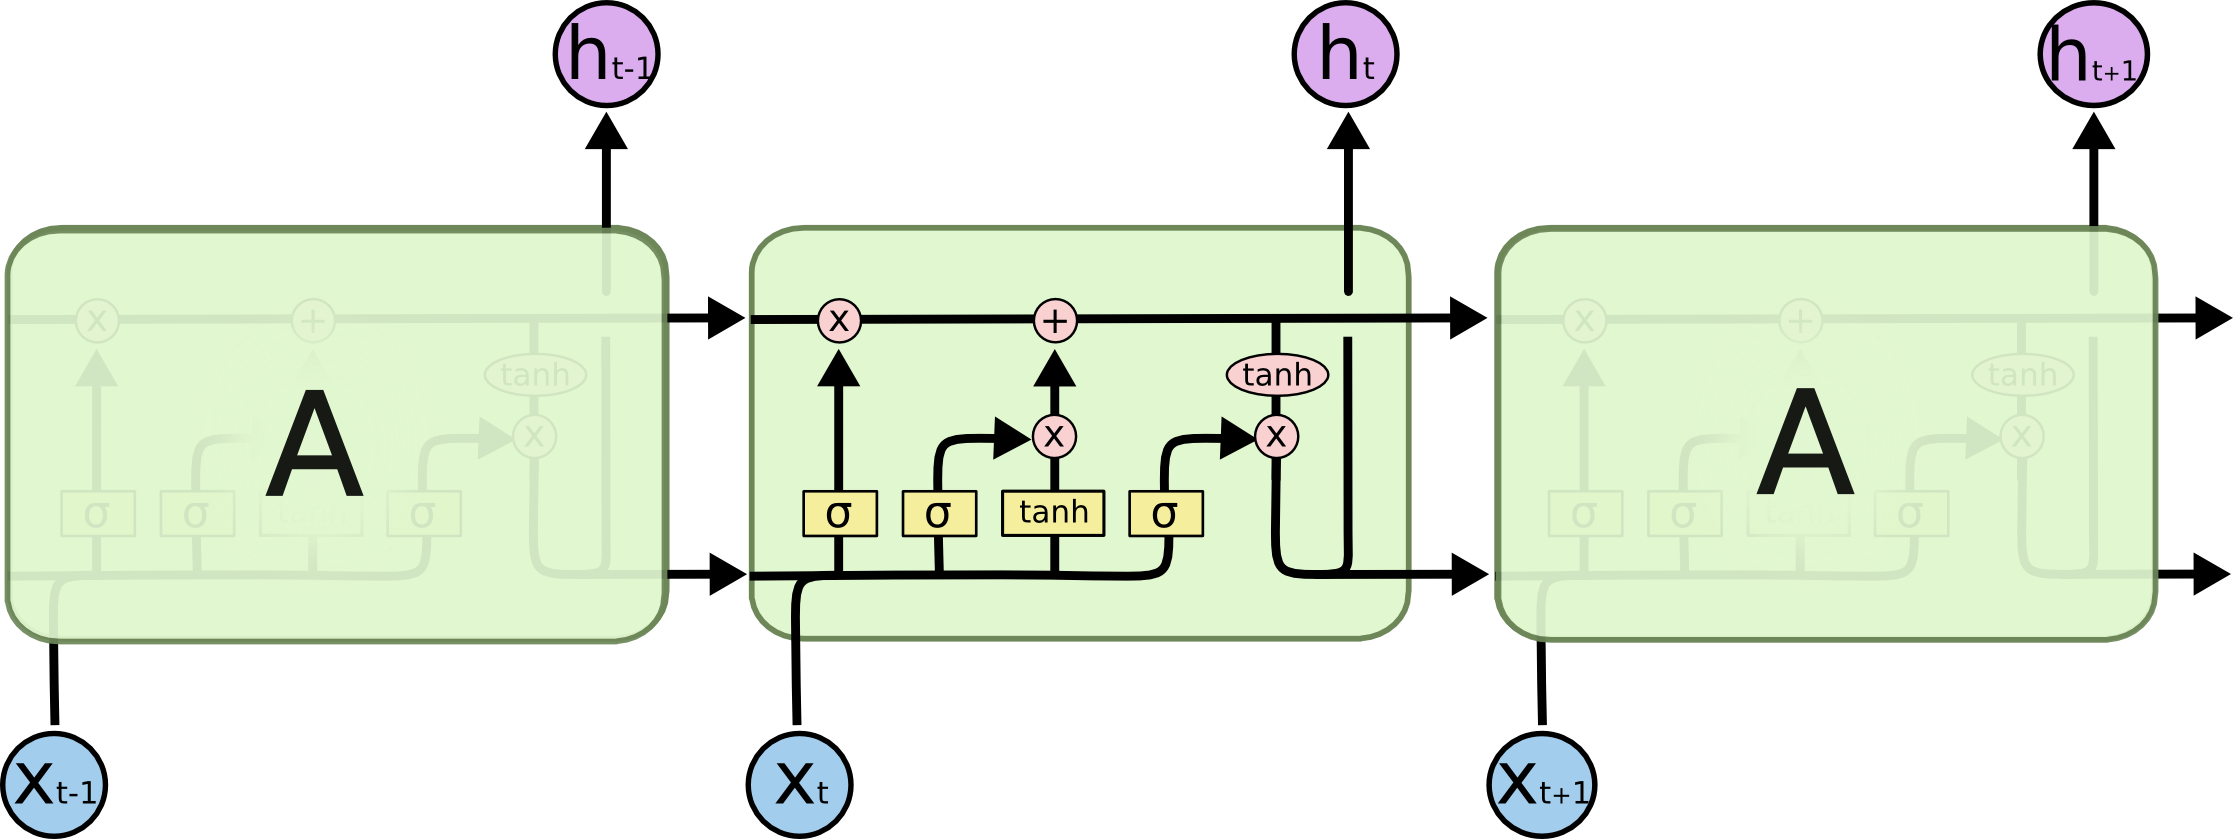

## BiLSTM
Another step up from the LSTM is the Bidirectional LSTM which uses two hidden layers, one running forward and another going backwards at the same time. Typically this is one from the past and future which allows the NN to have forward and backward information at that time.

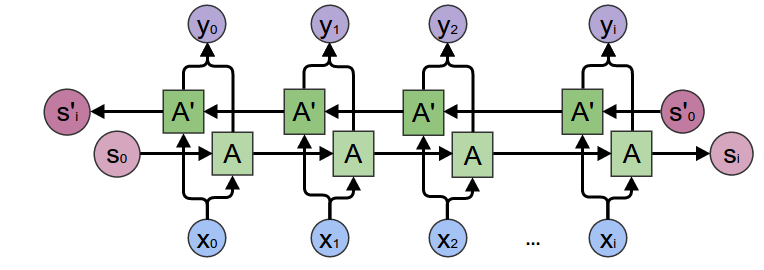

<sub>https://colah.github.io/posts/2015-08-Understanding-LSTMs/</sub>